In [1]:
packages <- c("ggplot2", "dplyr", "patchwork")
for (pkg in packages) {
    suppressPackageStartupMessages(
        suppressWarnings(
            library(
                pkg,
                character.only = TRUE,
                quietly = TRUE,
                warn.conflicts = FALSE
            )
        )
    )
}
source("../../../utils/r_themes.r")

In [2]:
umap_file_path <- file.path(
    "../../../data/umap/combined_umap_transformed.parquet"
)
mAP_file_path <- file.path(
    "../../../4.mAP_analysis/data/mAP/mAP_scores_CP_scDINO.parquet"
)
cell_count_file_path <- file.path(
    "../../../2.cell_tracks_data/data/combined_stats.parquet"
)
pca_file_path <- file.path(
    "../../../data/PCA/PCA_2D_combined_features.parquet"
)

# final figure path 
figures_path <- file.path("../figures")
if (!dir.exists(figures_path)) {
    dir.create(figures_path, recursive = TRUE)
}
final_figure_path <- file.path(
    figures_path,
    "metric_v_time_plot.png"
)

umap_df <- arrow::read_parquet(umap_file_path)
mAP_df <- arrow::read_parquet(mAP_file_path)
cell_count_df <- arrow::read_parquet(cell_count_file_path)
pca_df <- arrow::read_parquet(pca_file_path)


In [3]:
umap_df$Metadata_dose <- as.character(umap_df$Metadata_dose)
umap_df$Metadata_dose <- factor(
    umap_df$Metadata_dose, 
    levels = c(
        '0.0',
        '0.61',
        '1.22',
        '2.44',
        '4.88',
        '9.77',
        '19.53',
        '39.06',
        '78.13',
        '156.25'
    )
)

mAP_df$Metadata_dose <- as.character(mAP_df$Metadata_dose)
mAP_df$Metadata_dose <- factor(
    mAP_df$Metadata_dose, 
    levels = c(
        '0.0',
        '0.61',
        '1.22',
        '2.44',
        '4.88',
        '9.77',
        '19.53',
        '39.06',
        '78.13',
        '156.25'
    )
)
cell_count_df$Metadata_dose <- as.character(cell_count_df$Metadata_dose)
cell_count_df$Metadata_dose <- factor(
    cell_count_df$Metadata_dose, 
    levels = c(
        '0',
        '0.61',
        '1.22',
        '2.44',
        '4.88',
        '9.77',
        '19.53',
        '39.06',
        '78.13',
        '156.25'
    )
)
pca_df$Metadata_dose <- as.character(pca_df$Metadata_dose)
pca_df$Metadata_dose <- factor(
    pca_df$Metadata_dose, 
    levels = c(
        '0.0',
        '0.61',
        '1.22', 
        '2.44',
        '4.88',
        '9.77',
        '19.53',
        '39.06',
        '78.13',
        '156.25'
    )
)
umap_df$Metadata_Time <- as.numeric(umap_df$Metadata_Time) * 30
mAP_df$Metadata_Time <- as.numeric(mAP_df$Metadata_Time) * 30
cell_count_df$Metadata_Time <- as.numeric(cell_count_df$Metadata_Time) * 30
pca_df$Metadata_Time <- as.numeric(pca_df$Metadata_Time) * 30


# Plot mAP over time

In [4]:
# replace shuffle values with Shuffled and Not Shuffled
mAP_df$Shuffle <- gsub(
    "True", 
    "Shuffled", 
    mAP_df$Shuffle
)
mAP_df$Shuffle <- gsub(
    "False", 
    "Not Shuffled", 
    mAP_df$Shuffle
)

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


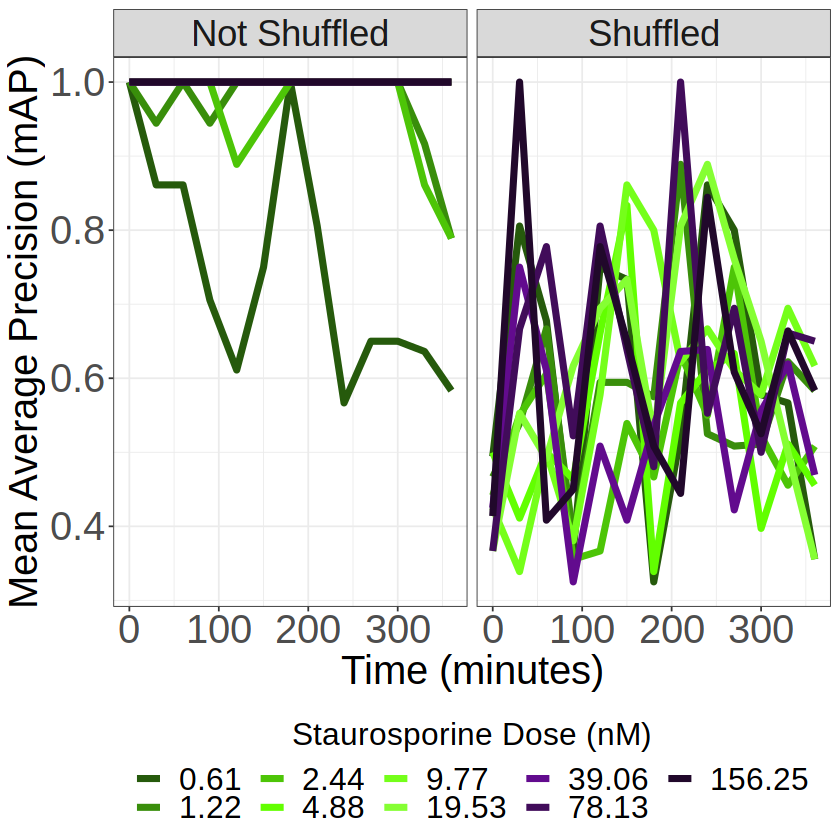

In [5]:
mAP_plot <- (
    ggplot(data = mAP_df, aes(x = Metadata_Time, y = mean_average_precision))
    + geom_line(aes(color = Metadata_dose), size = 2)
    + facet_wrap(Shuffle~.)
    + scale_color_manual(values = color_palette_dose)
    + labs(
        x = "Time (minutes)",
        y = "Mean Average Precision (mAP)",
        color = "Staurosporine Dose (nM)",
    )
    
    # change the legend title
    + guides(
        color = guide_legend(
            override.aes = list(size = 5),
            title.position = "top",
            title.hjust = 0.5,
            title.theme = element_text(size = font_size - 5 ),
            label.theme = element_text(size = font_size - 5),
            nrow = 2,
        ))
    + plot_themes

)
mAP_plot

In [6]:
umap_df$Metadata_dose_w_unit <- paste0(
    umap_df$Metadata_dose, 
    " nM"
)
umap_df$Metadata_dose_w_unit <- as.character(umap_df$Metadata_dose_w_unit)
umap_df$Metadata_dose_w_unit <- factor(
    umap_df$Metadata_dose_w_unit, 
    levels = c(
        '0.0 nM',
        '0.61 nM',
        '1.22 nM',
        '2.44 nM',
        '4.88 nM',
        '9.77 nM',
        '19.53 nM',
        '39.06 nM',
        '78.13 nM',
        '156.25 nM'
    )
)

## plot umap over time

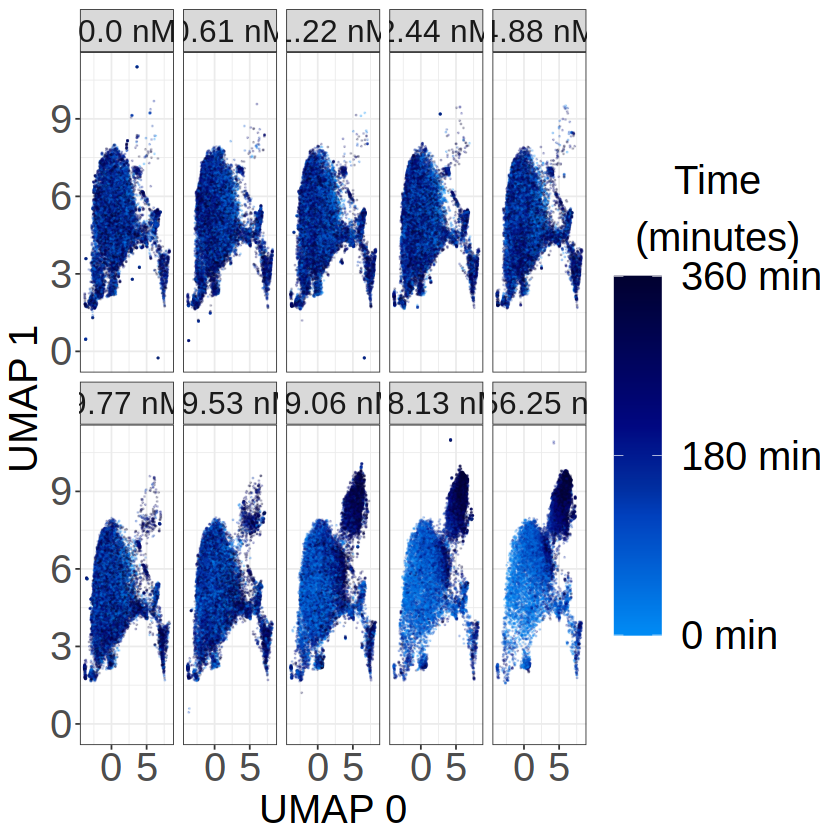

In [7]:
umap_df$Metadata_Time <- as.numeric(umap_df$Metadata_Time)
umap_plot_facet <- (
    ggplot(data = umap_df, aes(x = UMAP0, y = UMAP1))
    + geom_point(aes(color = Metadata_Time), size = 0.2, alpha = 0.2)
    + scale_color_gradientn(
        colors = temporal_palette,
        breaks = c(0, 180, 360), # breaks at 0, 90, and 360 minutes
        labels = c("0 min", "180 min", "360 min")
    )
    + labs(
        x = "UMAP 0",
        y = "UMAP 1",
        color = "Time\n(minutes)",
    )
    + facet_wrap(Metadata_dose_w_unit~., nrow = 2)
    + guides(
        color = guide_colorbar(
            title.position = "top",
            title.hjust = 0.5,
            title.theme = element_text(size = 24),
            # make the legend longer 
            barwidth = 2,
            # make the color bar on vertical
            barheight = 15,
        ))
    + plot_themes
    # override the facet strip text size
    + theme(
        strip.text = element_text(size = font_size - 5),
        legend.position = "right",
    )
)
umap_plot_facet

In [8]:

# calculate the centroid of each UMAP cluster dose and time wise
umap_df_centroids <- umap_df %>% group_by(Metadata_dose, Metadata_Time) %>% summarise(
    UMAP0_centroid = mean(UMAP0),
    UMAP1_centroid = mean(UMAP1)
)
umap_df_centroids$Metadata_Time <- as.numeric(gsub(" min", "", umap_df_centroids$Metadata_Time))
umap_df_centroids$Metadata_dose_w_unit <- paste0(
    umap_df_centroids$Metadata_dose, 
    " nM"
)
umap_df_centroids$Metadata_dose_w_unit <- as.character(umap_df_centroids$Metadata_dose_w_unit)
umap_df_centroids$Metadata_dose_w_unit <- factor(
    umap_df_centroids$Metadata_dose_w_unit, 
    levels = c(
        '0.0 nM',
        '0.61 nM',
        '1.22 nM',
        '2.44 nM',
        '4.88 nM',
        '9.77 nM',
        '19.53 nM',
        '39.06 nM',
        '78.13 nM',
        '156.25 nM'
    )
)

`summarise()` has grouped output by 'Metadata_dose'. You can override using the
`.groups` argument.


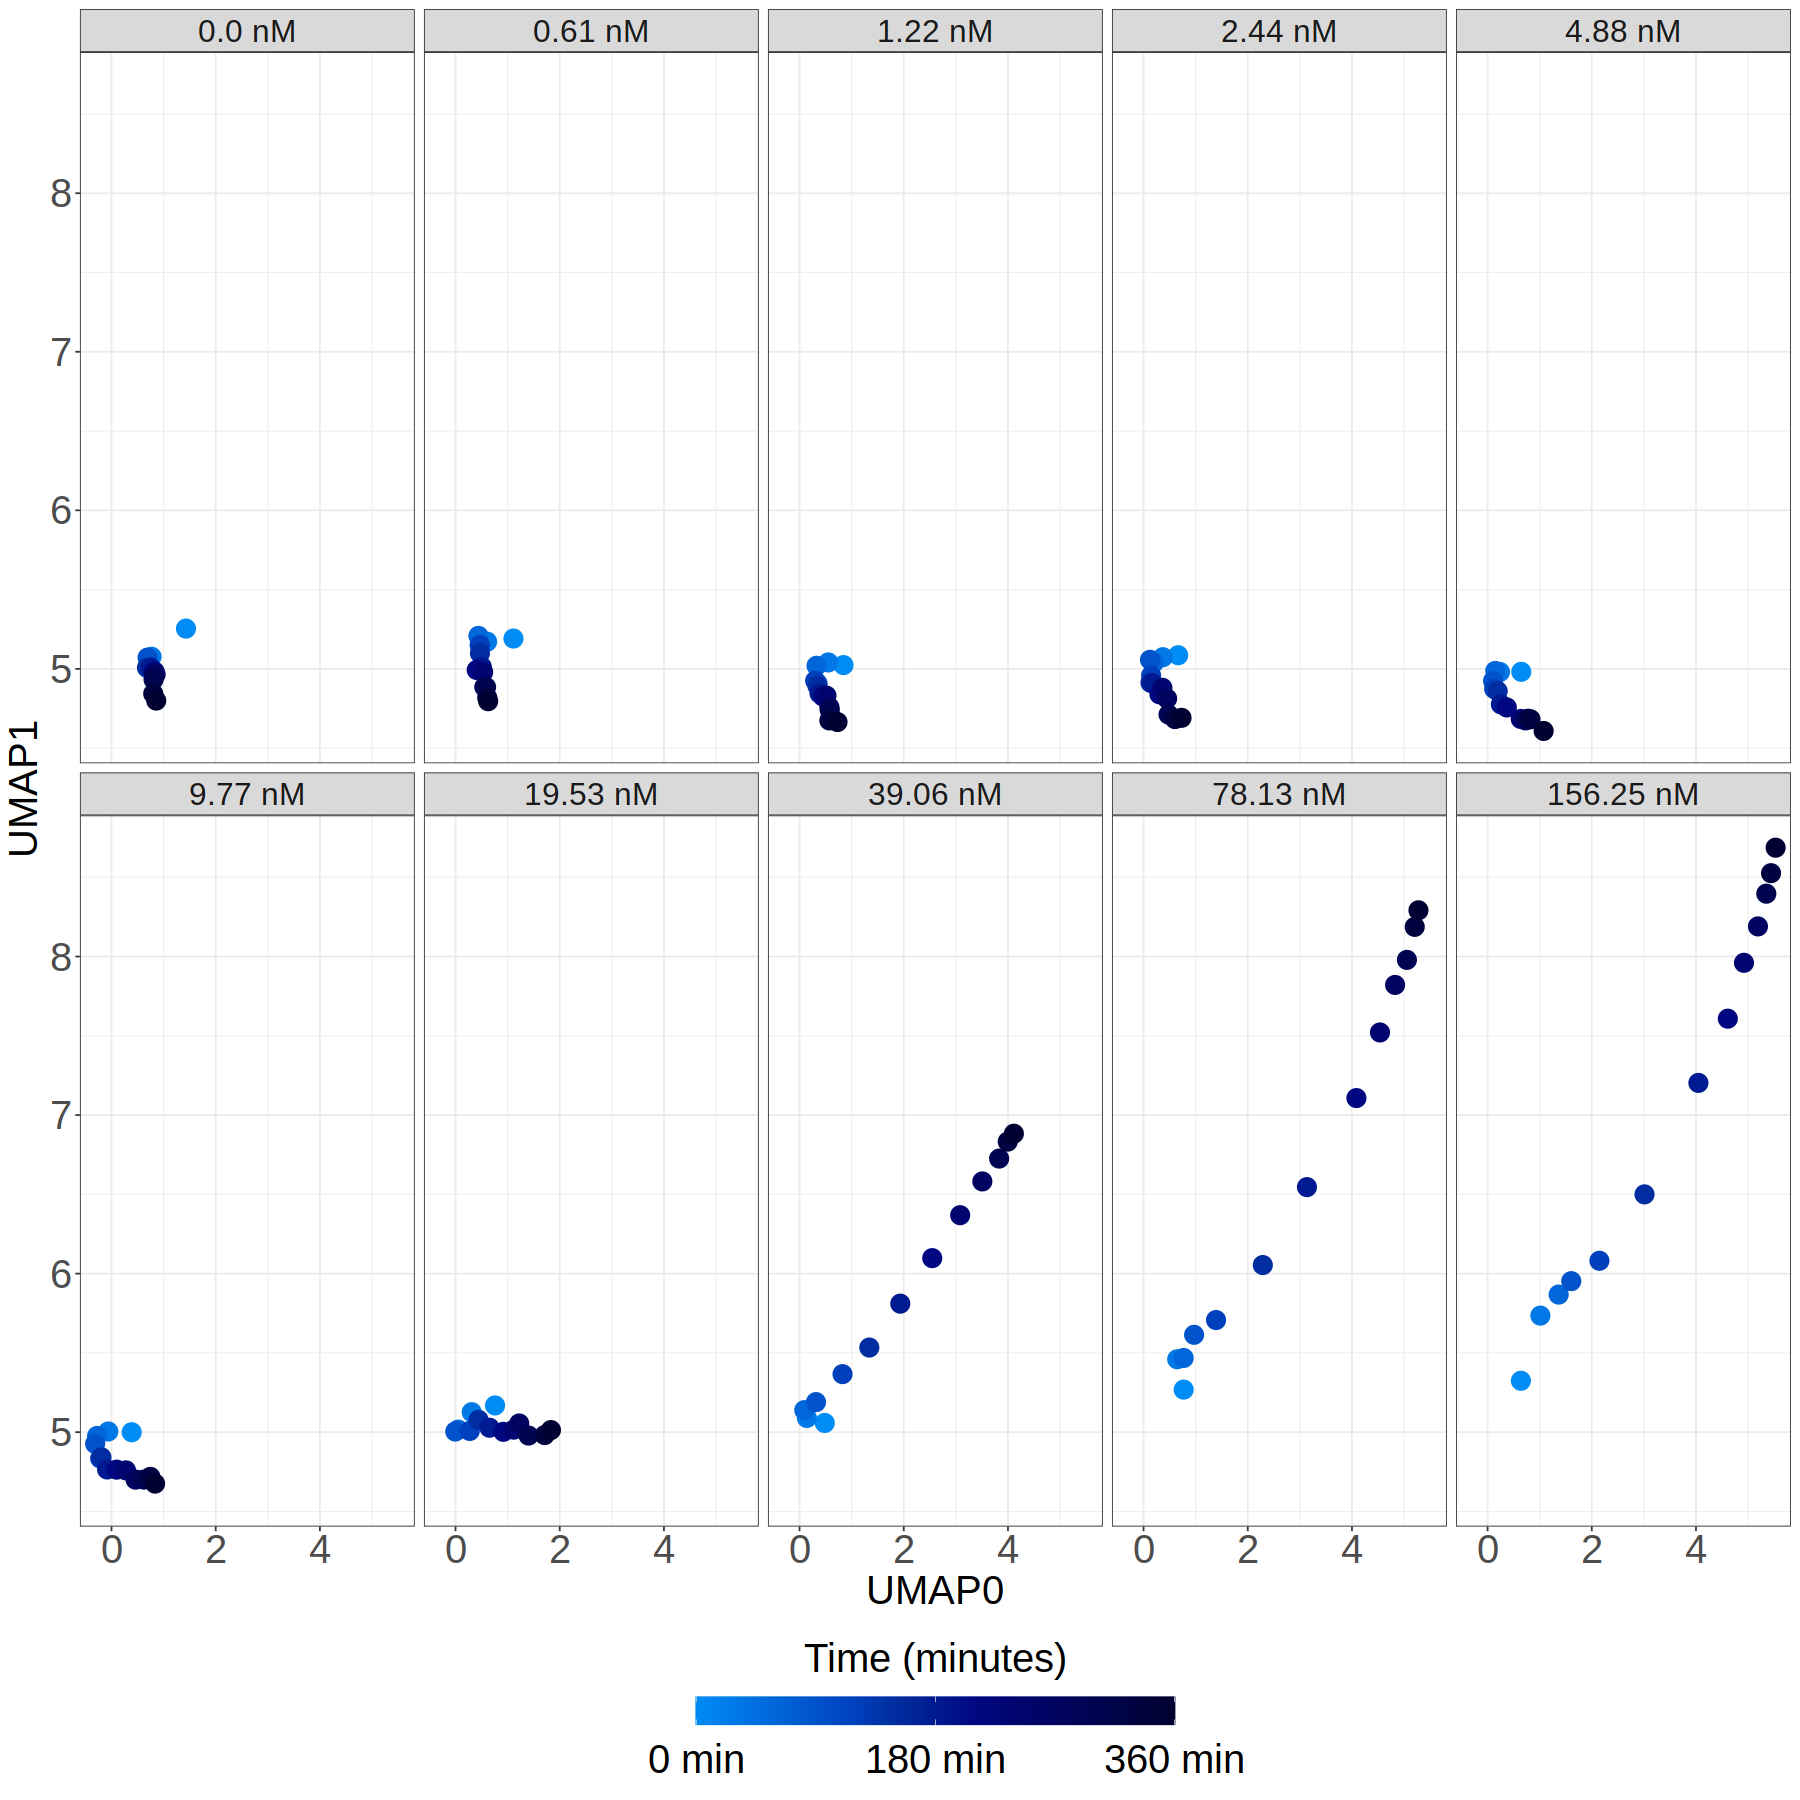

In [9]:

width <- 15
height <- 15
options(repr.plot.width = width, repr.plot.height = height)
# plot the centroids per dose over time
umap_centroid_plot <- (
    ggplot(data = umap_df_centroids, aes(x = UMAP0_centroid, y = UMAP1_centroid, color = Metadata_Time))
    + geom_point(size = 5)
    + theme_bw()
    + labs( x = "UMAP0", y = "UMAP1")
    # add custom colors
    + scale_color_gradientn(
        colors = temporal_palette,

        breaks = c(0, 180, 360), # breaks at 0, 90, and 360 minutes
        labels = c("0 min", "180 min", "360 min"),
        name = "Time (minutes)",
        guide = guide_colorbar(
            title.position = "top",
            title.hjust = 0.5,
            title.theme = element_text(size = 24),
            # make the legend longer 
            barwidth = 20
        )
    )
    + plot_themes
    + theme(strip.text = element_text(size = font_size - 5))
        
    + facet_wrap(~Metadata_dose_w_unit,nrow = 2)
    
)
umap_centroid_plot


# Assemble all plots into a single figure

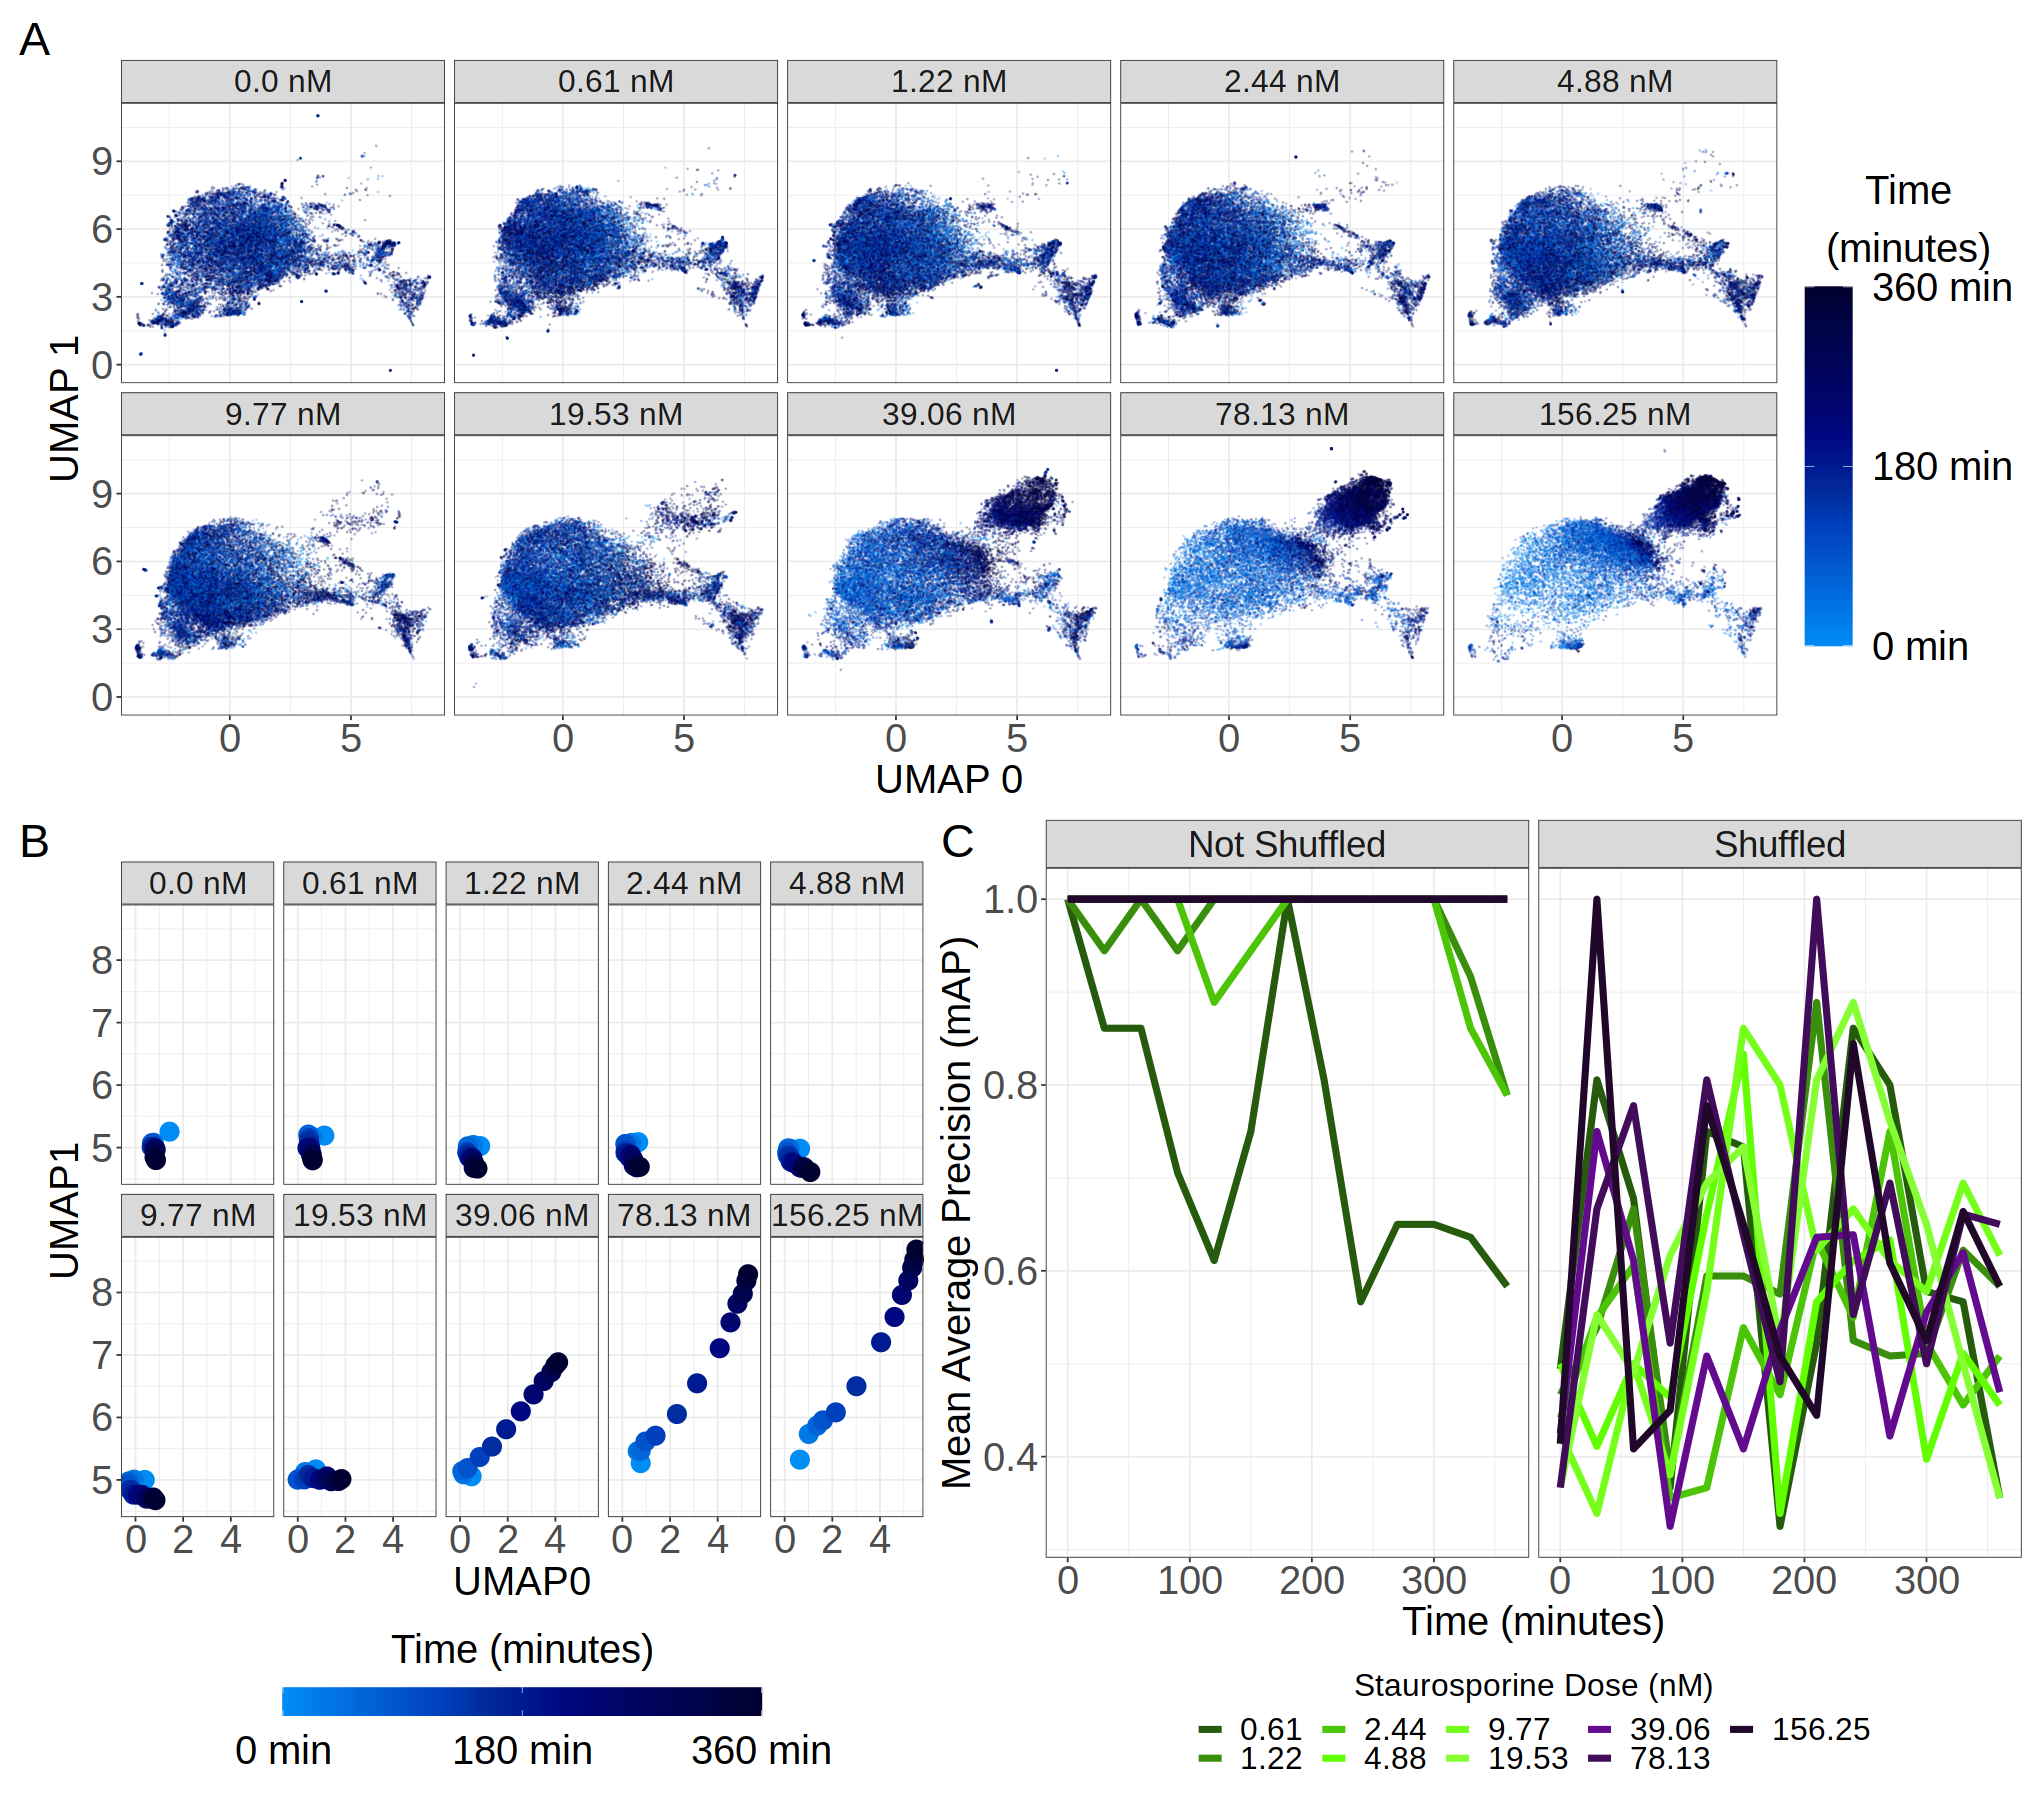

In [10]:
width <- 17
height <- 15
options(repr.plot.width=width, repr.plot.height=height)
layout <- "
AA
BC
"
metric_v_time_final_plot <- (
    umap_plot_facet
    + umap_centroid_plot
    + wrap_elements(full = mAP_plot)

    + plot_layout(
        design = layout,
        widths = c(1, 1)
        )
    # make bottom plot not align
    + plot_annotation(tag_levels = 'A') & theme(plot.tag = element_text(size = 28))
)
ggsave(
    filename = final_figure_path,
    plot = metric_v_time_final_plot,
    width = width,
    height = height,
    dpi = 600
)
metric_v_time_final_plot